In [1]:
# pip install git+https://github.com/IBM/tsfm.git
# pip install transformers
# pip install bottleneck --upgrade

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import EarlyStoppingCallback, PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index


In [2]:
dataset_path = r"Data\participant_training_jobs_full_data.csv"
timestamp_column = "timestamp"
id_columns = ['job_id', 'host']
forecast_columns = ['block','cpuuser','gpu_usage','memused','memused_minus_diskcache','nfs']
context_length = 12
forecast_horizon = 1
patch_length = 6
num_workers = 12
batch_size = 64

In [4]:
data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta'], axis=1, inplace=True)
# data.drop(['ts_delta','job_id', 'host'], axis=1, inplace=True)

# num_train = int(len(data) * 0.7)
# num_test = int(len(data) * 0.2)
# num_valid = len(data) - num_train - num_test
# border1s = [
#     0,
#     num_train - context_length,
#     len(data) - num_test - context_length,
# ]
# border2s = [num_train, num_train + num_valid, len(data)]

# train_start_index = border1s[0]  # None indicates beginning of dataset
# train_end_index = border2s[0]

# # we shift the start of the evaluation period back by context length so that
# # the first evaluation timestamp is immediately following the training data
# valid_start_index = border1s[1]
# valid_end_index = border2s[1]

# test_start_index = border1s[2]
# test_end_index = border2s[2]

# train_data = select_by_index(
#     data,
#     id_columns=id_columns,
#     start_index=train_start_index,
#     end_index=train_end_index,
# )
# valid_data = select_by_index(
#     data,
#     id_columns=id_columns,
#     start_index=valid_start_index,
#     end_index=valid_end_index,
# )

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=0,
    end_index=60,
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=60-context_length,
    end_index=None,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=15, # 16
    num_hidden_layers=3,
    ffn_dim=180, # 256
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="layernorm",
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results",
    overwrite_output_dir=True,
    num_train_epochs=50,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [5]:
trainer.train()

  0%|          | 0/51400 [00:00<?, ?it/s]

{'loss': 0.8464, 'grad_norm': 1.5909976959228516, 'learning_rate': 4.9e-05, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 726.629150390625, 'eval_runtime': 83.5002, 'eval_samples_per_second': 151.401, 'eval_steps_per_second': 2.371, 'epoch': 1.0}
{'loss': 0.8262, 'grad_norm': 1.7116416692733765, 'learning_rate': 4.8e-05, 'epoch': 2.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 724.1863403320312, 'eval_runtime': 84.8393, 'eval_samples_per_second': 149.011, 'eval_steps_per_second': 2.334, 'epoch': 2.0}
{'loss': 0.8225, 'grad_norm': 2.4813547134399414, 'learning_rate': 4.7e-05, 'epoch': 3.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 721.103515625, 'eval_runtime': 81.5377, 'eval_samples_per_second': 155.045, 'eval_steps_per_second': 2.428, 'epoch': 3.0}
{'loss': 0.8202, 'grad_norm': 1.177720069885254, 'learning_rate': 4.600000000000001e-05, 'epoch': 4.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 720.5158081054688, 'eval_runtime': 88.7034, 'eval_samples_per_second': 142.52, 'eval_steps_per_second': 2.232, 'epoch': 4.0}
{'loss': 0.8181, 'grad_norm': 1.4518884420394897, 'learning_rate': 4.5e-05, 'epoch': 5.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 721.40966796875, 'eval_runtime': 83.5109, 'eval_samples_per_second': 151.381, 'eval_steps_per_second': 2.371, 'epoch': 5.0}
{'loss': 0.8169, 'grad_norm': 1.6192355155944824, 'learning_rate': 4.4000000000000006e-05, 'epoch': 6.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 715.2838745117188, 'eval_runtime': 81.4092, 'eval_samples_per_second': 155.29, 'eval_steps_per_second': 2.432, 'epoch': 6.0}
{'loss': 0.8162, 'grad_norm': 1.7856686115264893, 'learning_rate': 4.3e-05, 'epoch': 7.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 720.3466796875, 'eval_runtime': 88.2266, 'eval_samples_per_second': 143.29, 'eval_steps_per_second': 2.244, 'epoch': 7.0}
{'loss': 0.8154, 'grad_norm': 2.5751562118530273, 'learning_rate': 4.2e-05, 'epoch': 8.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 717.9492797851562, 'eval_runtime': 79.9769, 'eval_samples_per_second': 158.071, 'eval_steps_per_second': 2.476, 'epoch': 8.0}
{'loss': 0.8138, 'grad_norm': 1.7730780839920044, 'learning_rate': 4.1e-05, 'epoch': 9.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 719.1455688476562, 'eval_runtime': 80.2462, 'eval_samples_per_second': 157.54, 'eval_steps_per_second': 2.467, 'epoch': 9.0}
{'loss': 0.8127, 'grad_norm': 1.6188784837722778, 'learning_rate': 4e-05, 'epoch': 10.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 721.0416259765625, 'eval_runtime': 83.6427, 'eval_samples_per_second': 151.143, 'eval_steps_per_second': 2.367, 'epoch': 10.0}
{'loss': 0.8126, 'grad_norm': 0.7044927477836609, 'learning_rate': 3.9000000000000006e-05, 'epoch': 11.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 716.1089477539062, 'eval_runtime': 83.03, 'eval_samples_per_second': 152.258, 'eval_steps_per_second': 2.385, 'epoch': 11.0}
{'loss': 0.8117, 'grad_norm': 0.9387564659118652, 'learning_rate': 3.8e-05, 'epoch': 12.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 716.2679443359375, 'eval_runtime': 87.0932, 'eval_samples_per_second': 145.155, 'eval_steps_per_second': 2.273, 'epoch': 12.0}
{'loss': 0.8108, 'grad_norm': 2.888840436935425, 'learning_rate': 3.7e-05, 'epoch': 13.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 718.6478271484375, 'eval_runtime': 86.3326, 'eval_samples_per_second': 146.434, 'eval_steps_per_second': 2.293, 'epoch': 13.0}
{'loss': 0.8104, 'grad_norm': 1.321869969367981, 'learning_rate': 3.6e-05, 'epoch': 14.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 721.358154296875, 'eval_runtime': 86.0802, 'eval_samples_per_second': 146.863, 'eval_steps_per_second': 2.3, 'epoch': 14.0}
{'loss': 0.8109, 'grad_norm': 1.2507907152175903, 'learning_rate': 3.5e-05, 'epoch': 15.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 714.7667236328125, 'eval_runtime': 77.1099, 'eval_samples_per_second': 163.948, 'eval_steps_per_second': 2.568, 'epoch': 15.0}
{'loss': 0.8088, 'grad_norm': 0.9812197685241699, 'learning_rate': 3.4000000000000007e-05, 'epoch': 16.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 721.650146484375, 'eval_runtime': 84.0186, 'eval_samples_per_second': 150.467, 'eval_steps_per_second': 2.357, 'epoch': 16.0}
{'loss': 0.8084, 'grad_norm': 1.68346107006073, 'learning_rate': 3.3e-05, 'epoch': 17.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 715.9463500976562, 'eval_runtime': 86.2796, 'eval_samples_per_second': 146.524, 'eval_steps_per_second': 2.295, 'epoch': 17.0}
{'loss': 0.8082, 'grad_norm': 1.4001210927963257, 'learning_rate': 3.2000000000000005e-05, 'epoch': 18.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 718.7810668945312, 'eval_runtime': 86.4439, 'eval_samples_per_second': 146.245, 'eval_steps_per_second': 2.291, 'epoch': 18.0}
{'loss': 0.8074, 'grad_norm': 2.253918170928955, 'learning_rate': 3.1e-05, 'epoch': 19.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 724.7742309570312, 'eval_runtime': 86.8077, 'eval_samples_per_second': 145.632, 'eval_steps_per_second': 2.281, 'epoch': 19.0}
{'loss': 0.8067, 'grad_norm': 8.251970291137695, 'learning_rate': 3e-05, 'epoch': 20.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 725.4999389648438, 'eval_runtime': 86.4665, 'eval_samples_per_second': 146.207, 'eval_steps_per_second': 2.29, 'epoch': 20.0}
{'loss': 0.8062, 'grad_norm': 1.9434635639190674, 'learning_rate': 2.9e-05, 'epoch': 21.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 717.1055297851562, 'eval_runtime': 86.5071, 'eval_samples_per_second': 146.138, 'eval_steps_per_second': 2.289, 'epoch': 21.0}
{'loss': 0.8057, 'grad_norm': 3.508218765258789, 'learning_rate': 2.8000000000000003e-05, 'epoch': 22.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 716.6134033203125, 'eval_runtime': 86.2033, 'eval_samples_per_second': 146.653, 'eval_steps_per_second': 2.297, 'epoch': 22.0}
{'loss': 0.8053, 'grad_norm': 2.38893723487854, 'learning_rate': 2.7000000000000002e-05, 'epoch': 23.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 719.7108154296875, 'eval_runtime': 84.7083, 'eval_samples_per_second': 149.242, 'eval_steps_per_second': 2.337, 'epoch': 23.0}
{'loss': 0.8047, 'grad_norm': 2.0797314643859863, 'learning_rate': 2.6000000000000002e-05, 'epoch': 24.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 715.8036499023438, 'eval_runtime': 87.7379, 'eval_samples_per_second': 144.088, 'eval_steps_per_second': 2.257, 'epoch': 24.0}
{'loss': 0.8048, 'grad_norm': 2.2608375549316406, 'learning_rate': 2.5e-05, 'epoch': 25.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 717.7557373046875, 'eval_runtime': 87.4015, 'eval_samples_per_second': 144.643, 'eval_steps_per_second': 2.265, 'epoch': 25.0}
{'train_runtime': 3599.4077, 'train_samples_per_second': 913.484, 'train_steps_per_second': 14.28, 'train_loss': 0.8132418336385883, 'epoch': 25.0}


TrainOutput(global_step=25700, training_loss=0.8132418336385883, metrics={'train_runtime': 3599.4077, 'train_samples_per_second': 913.484, 'train_steps_per_second': 14.28, 'total_flos': 140877569088000.0, 'train_loss': 0.8132418336385883, 'epoch': 25.0})

In [6]:
predictions = trainer.predict(test_dataset=val_dataset)

  0%|          | 0/198 [00:00<?, ?it/s]

In [7]:
def trainer_prediction_output_to_df(output, idx:int, count:int=12642):
    return pd.DataFrame({
        'block':list(output[0][idx].reshape((count,6))[:, 0])+list(output[1].reshape((count,6))[:, 0]),
        'cpuuser':list(output[0][idx].reshape((count,6))[:, 1])+list(output[1].reshape((count,6))[:, 1]),
        'gpu_usage':list(output[0][idx].reshape((count,6))[:, 2])+list(output[1].reshape((count,6))[:, 2]),
        'memused':list(output[0][idx].reshape((count,6))[:, 3])+list(output[1].reshape((count,6))[:, 3]),
        'memused_minus_diskcache':list(output[0][1].reshape((count,6))[:, 4])+list(output[1].reshape((count,6))[:, 4]),
        'nfs':list(output[0][idx].reshape((count,6))[:, 5])+list(output[1].reshape((count,6))[:, 5]),
        'type':['prediction']*count + ['truth']*count
        })
    

In [8]:
def trainer_prediction_output_to_df_v2(output):
    return pd.DataFrame({
        'block_prediction':output[0][1].reshape((12642,6))[:, 0],
        'block_truth':output[1].reshape((12642,6))[:, 0],
        'cpuuser_prediction':output[0][1].reshape((12642,6))[:, 1],
        'cpuuser_truth':output[1].reshape((12642,6))[:, 1],
        'gpu_usage_prediction':output[0][1].reshape((12642,6))[:, 2],
        'gpu_usage_truth':output[1].reshape((12642,6))[:, 2],
        'memused_prediction':output[0][1].reshape((12642,6))[:, 3],
        'memused_truth':output[1].reshape((12642,6))[:, 3],
        'memused_minus_diskcache_prediction':output[0][1].reshape((12642,6))[:, 4],
        'memused_minus_diskcache_truth':output[1].reshape((12642,6))[:, 4],
        'nfs_prediction':output[0][1].reshape((12642,6))[:, 5],
        'nfs_truth':output[1].reshape((12642,6))[:, 5]
    })

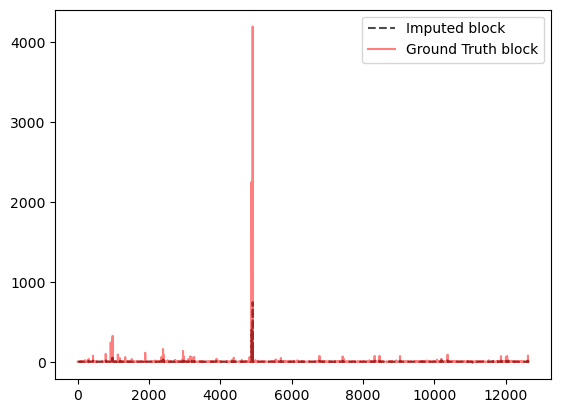

RMSE: 43.638647354939295


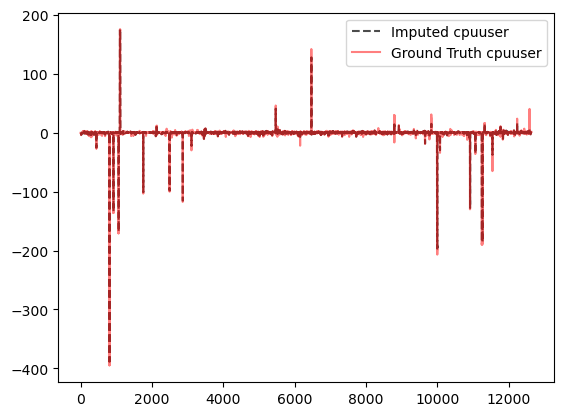

RMSE: 6.914868530877244


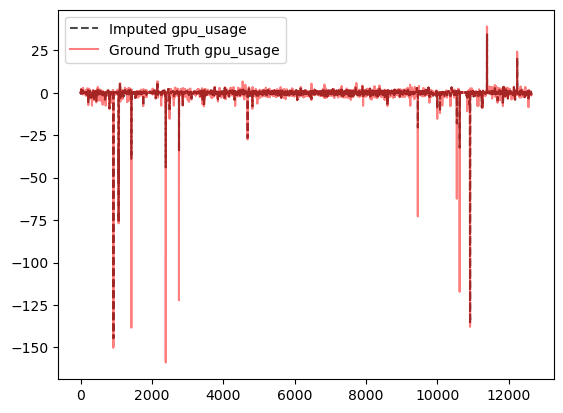

RMSE: 3.9733844040995705


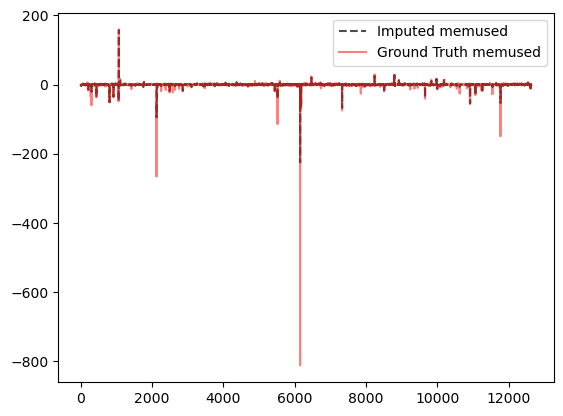

RMSE: 9.955856930432372


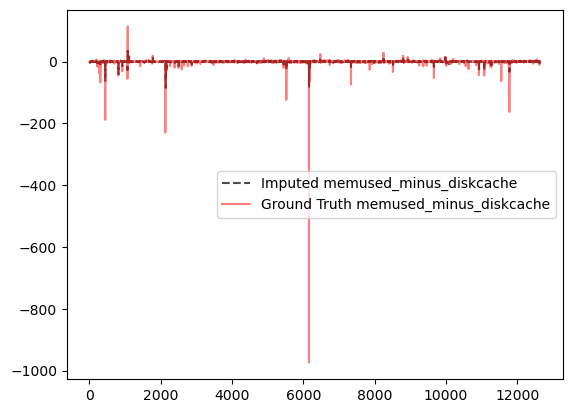

RMSE: 13.40241946113124


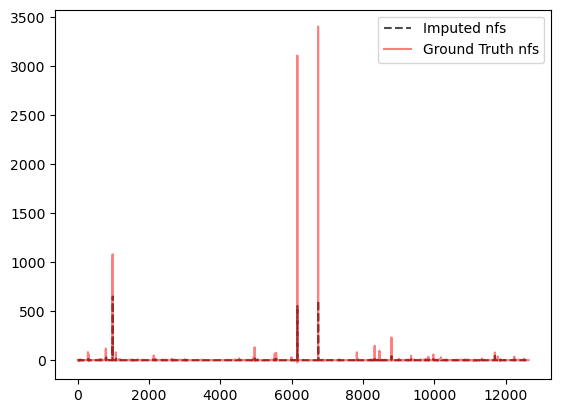

RMSE: 45.668980300842605


In [9]:
val_out = trainer_prediction_output_to_df(predictions, 0)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [10]:
config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=15, # 16
    num_hidden_layers=3,
    ffn_dim=180, # 256
    dropout=0.05,
    head_dropout=0.05,
    pooling_type=None,
    channel_attention=False,
    scaling=None,
    loss="mse",
    pre_norm=True,
    norm_type="layernorm",
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results",
    overwrite_output_dir=True,
    num_train_epochs=50,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
trainer.train()

  0%|          | 0/51400 [00:00<?, ?it/s]

{'loss': 0.8001, 'grad_norm': 1.4100489616394043, 'learning_rate': 4.9e-05, 'epoch': 1.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 799.52197265625, 'eval_runtime': 88.6224, 'eval_samples_per_second': 142.65, 'eval_steps_per_second': 2.234, 'epoch': 1.0}
{'loss': 0.7603, 'grad_norm': 1.8121569156646729, 'learning_rate': 4.8e-05, 'epoch': 2.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 803.2330322265625, 'eval_runtime': 85.1951, 'eval_samples_per_second': 148.389, 'eval_steps_per_second': 2.324, 'epoch': 2.0}
{'loss': 0.7502, 'grad_norm': 4.603561878204346, 'learning_rate': 4.7e-05, 'epoch': 3.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 806.0868530273438, 'eval_runtime': 84.439, 'eval_samples_per_second': 149.718, 'eval_steps_per_second': 2.345, 'epoch': 3.0}
{'loss': 0.7462, 'grad_norm': 1.6310352087020874, 'learning_rate': 4.600000000000001e-05, 'epoch': 4.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 808.5142211914062, 'eval_runtime': 88.6315, 'eval_samples_per_second': 142.636, 'eval_steps_per_second': 2.234, 'epoch': 4.0}
{'loss': 0.7431, 'grad_norm': 1.4267950057983398, 'learning_rate': 4.5e-05, 'epoch': 5.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 810.6629638671875, 'eval_runtime': 85.3254, 'eval_samples_per_second': 148.162, 'eval_steps_per_second': 2.321, 'epoch': 5.0}
{'loss': 0.7414, 'grad_norm': 2.233243465423584, 'learning_rate': 4.4000000000000006e-05, 'epoch': 6.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 811.7008666992188, 'eval_runtime': 85.443, 'eval_samples_per_second': 147.958, 'eval_steps_per_second': 2.317, 'epoch': 6.0}
{'loss': 0.741, 'grad_norm': 2.5212223529815674, 'learning_rate': 4.3e-05, 'epoch': 7.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 812.888916015625, 'eval_runtime': 88.8192, 'eval_samples_per_second': 142.334, 'eval_steps_per_second': 2.229, 'epoch': 7.0}
{'loss': 0.7396, 'grad_norm': 6.782023906707764, 'learning_rate': 4.2e-05, 'epoch': 8.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 813.4794921875, 'eval_runtime': 84.8018, 'eval_samples_per_second': 149.077, 'eval_steps_per_second': 2.335, 'epoch': 8.0}
{'loss': 0.7382, 'grad_norm': 1.7534257173538208, 'learning_rate': 4.1e-05, 'epoch': 9.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 814.2255249023438, 'eval_runtime': 88.9861, 'eval_samples_per_second': 142.067, 'eval_steps_per_second': 2.225, 'epoch': 9.0}
{'loss': 0.737, 'grad_norm': 2.910824775695801, 'learning_rate': 4e-05, 'epoch': 10.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 815.3418579101562, 'eval_runtime': 86.1754, 'eval_samples_per_second': 146.701, 'eval_steps_per_second': 2.298, 'epoch': 10.0}
{'loss': 0.7366, 'grad_norm': 1.5711712837219238, 'learning_rate': 3.9000000000000006e-05, 'epoch': 11.0}


  0%|          | 0/198 [00:00<?, ?it/s]

{'eval_loss': 816.0079956054688, 'eval_runtime': 88.7354, 'eval_samples_per_second': 142.469, 'eval_steps_per_second': 2.231, 'epoch': 11.0}
{'train_runtime': 1598.5349, 'train_samples_per_second': 2056.884, 'train_steps_per_second': 32.154, 'train_loss': 0.7485282960020699, 'epoch': 11.0}


TrainOutput(global_step=11308, training_loss=0.7485282960020699, metrics={'train_runtime': 1598.5349, 'train_samples_per_second': 2056.884, 'train_steps_per_second': 32.154, 'total_flos': 61986130398720.0, 'train_loss': 0.7485282960020699, 'epoch': 11.0})

In [12]:
predictions = trainer.predict(test_dataset=val_dataset)

  0%|          | 0/198 [00:00<?, ?it/s]

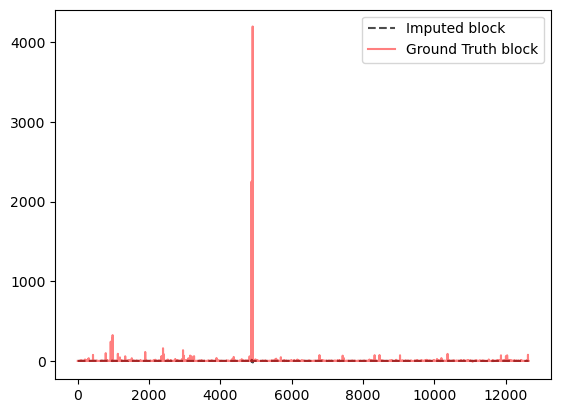

RMSE: 44.629983746566054


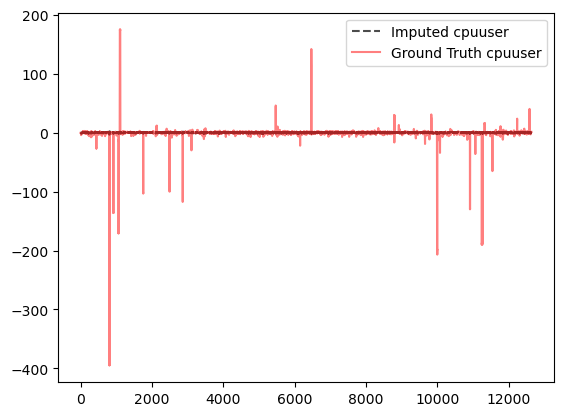

RMSE: 17.878994582068227


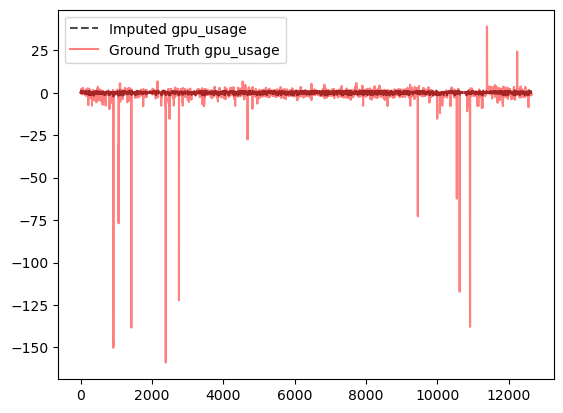

RMSE: 5.9090207982739065


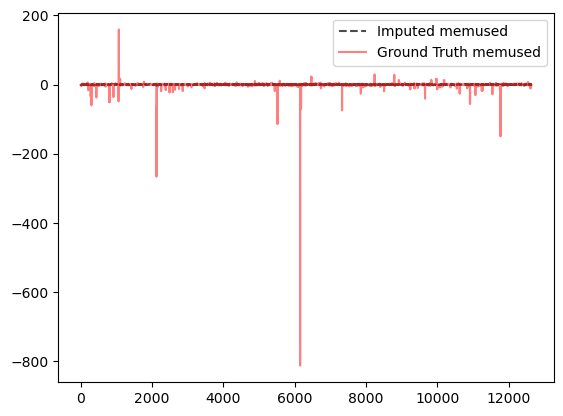

RMSE: 12.37921502356306


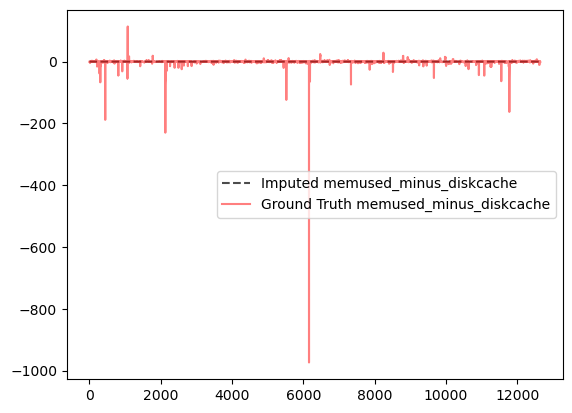

RMSE: 14.35158057463478


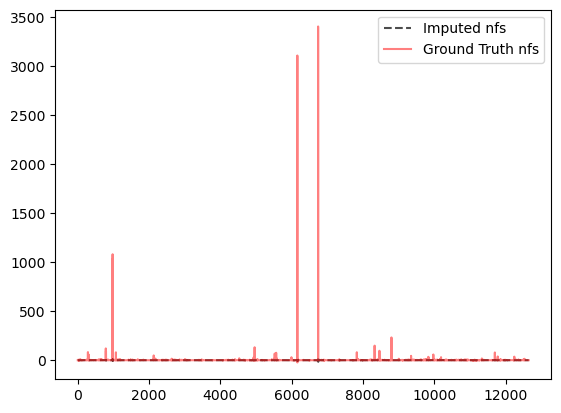

RMSE: 45.754284934241404


In [13]:
val_out = trainer_prediction_output_to_df(predictions, 0)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [12]:
# alt

id_columns = []

data = pd.read_csv(dataset_path, parse_dates=[timestamp_column])
data.drop(['ts_delta','job_id', 'host'], axis=1, inplace=True)

num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]
train_end_index = border2s[0]

valid_start_index = border1s[1]
valid_end_index = border2s[1]


train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
val_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)

time_series_preprocessor = time_series_preprocessor.train(train_data)

train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
val_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(val_data),
    id_columns=id_columns,
    timestamp_column="timestamp",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.2,
    d_model=90, # 128
    num_attention_heads=15, # 16
    num_hidden_layers=3,
    ffn_dim=180, # 256
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

training_args = TrainingArguments(
    output_dir=r"Data\results_alt",
    overwrite_output_dir=True,
    num_train_epochs=2,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir=r"Data\logs_alt",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

c:\Users\danie\anaconda3\envs\new_env\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer.train()

  0%|          | 0/2076 [00:00<?, ?it/s]

{'loss': 0.6279, 'grad_norm': 4.914384365081787, 'learning_rate': 2.5e-05, 'epoch': 1.0}


  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.1677304357290268, 'eval_runtime': 71.2286, 'eval_samples_per_second': 133.163, 'eval_steps_per_second': 2.092, 'epoch': 1.0}
{'loss': 0.5977, 'grad_norm': 2.7795047760009766, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.1653745174407959, 'eval_runtime': 68.6364, 'eval_samples_per_second': 138.192, 'eval_steps_per_second': 2.171, 'epoch': 2.0}
{'train_runtime': 245.2249, 'train_samples_per_second': 541.356, 'train_steps_per_second': 8.466, 'train_loss': 0.6127854716571081, 'epoch': 2.0}


TrainOutput(global_step=2076, training_loss=0.6127854716571081, metrics={'train_runtime': 245.2249, 'train_samples_per_second': 541.356, 'train_steps_per_second': 8.466, 'total_flos': 9180716507424.0, 'train_loss': 0.6127854716571081, 'epoch': 2.0})

In [22]:
predictions = trainer.predict(test_dataset=val_dataset)

In [ ]:
val_out = trainer_prediction_output_to_df(predictions, 0)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")

In [ ]:
val_out = trainer_prediction_output_to_df(predictions, 1)
val_p = val_out[val_out['type']=='prediction']
val_t = val_out[val_out['type']=='truth'].reset_index(drop=True)
for col in forecast_columns:
  plt.plot(val_p.index, val_p[col], label=f'Imputed {col}', linestyle='--', color='black', alpha=0.7)
  plt.plot(val_t.index, val_t[col], label=f'Ground Truth {col}', linestyle='-', color='red', alpha=0.5)
  plt.legend()
  plt.show()
  plt.close()
  error = val_p[col].to_numpy()-val_t[col].to_numpy()
  errors_squared = error**2
  print(f"RMSE: {math.sqrt(np.mean(errors_squared))}")